## OPTECH. Use Case 1
### Phase 2
#### Based on paper: X. Liu, B. Wang  and Z. Yang, "Virtual Network Embedding Based on Topology Potential, " Entropy 2018, 20(12), 941.

In [1]:
# Libraries needed
import networkx as nx
import math
import random
import numpy
import time

from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.core import Var

import sqlite3

## SCENARIO


In [2]:
# Generate the attributes 'location' and 'cpu' of the nodes of a network
def GenerateAttribNetworkNodes( G, minCPU, maxCPU ):
    distribCPU = numpy.random.randint( minCPU, maxCPU, len(G.nodes()) ) # distribution of nodes CPU
    for n in list(G.nodes()):
        G.nodes[n]['loc']=(0,0) 
    for n in list(G.nodes()):
        position = False
        l = [G.nodes[n]['loc'] for n in list(G.nodes())]
        while not position:
            x = numpy.random.randint( minX, maxX, 1)
            y = numpy.random.randint( minY, maxY, 1)
            if (x,y) not in l:
                G.nodes[n]['loc']=(x,y)
                position = True
            G.nodes[n]['cpu'] = distribCPU[n]

    return G


# Generate the attributes 'distance' and 'bw' of the links of a network
def GenerateAttribNetworkLinks( G, minBW, maxBW ):
    distribBW = numpy.random.randint( minBW, maxBW, len(G.edges()) ) # distribution of links BW
    for idx, link in enumerate(list(G.edges())):
        bw = int(round(distribBW[idx]))
        G.edges[(link[0],link[1])]['bw'] = distribBW[idx]
        G.edges[(link[1],link[0])]['bw'] = distribBW[idx]
        G.edges[link]['dist'] = Distance( G.nodes[link[0]]['loc'], G.nodes[link[1]]['loc'] )

    return G


# Calculate the distance between two nodes
def Distance(p1, p2):
    return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)

In [3]:
# Location of nodes (physical and virtuals)
minX = 1
maxX= 1000
minY = 1
maxY = 1000

### PHYSICAL NETWORK


In [4]:
NumNodes = 100
Degree = 10

# Nodes CPU
minCPU = 50
maxCPU = 100

# Link BW
minBW= 50
maxBW = 100

def GeneratePhysicalNetwork(): 
    # Generate a random physical network with NumNodes nodes and NumNodes*Degree/2 bidirectional links
    Gp = nx.random_regular_graph( Degree, NumNodes )
    # Fill the nodes and links attributes
    GenerateAttribNetworkNodes( Gp, minCPU, maxCPU )
    GenerateAttribNetworkLinks( Gp, minBW, maxBW )
    
    # Maintain information about the procedures of embedding
    for n in list(Gp.nodes()):
        Gp.nodes[n]['numVNodes'] = 0
    for edge in list(Gp.edges()):
        Gp.edges[edge]['numVLinks'] = 0

    # Relabel the number of nodes to start from 1 (instead of 0)
    Gp = nx.convert_node_labels_to_integers(Gp, first_label=1, ordering='sorted', label_attribute=None)

    return Gp
    

/tmp/ipykernel_26843/2458749659.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)


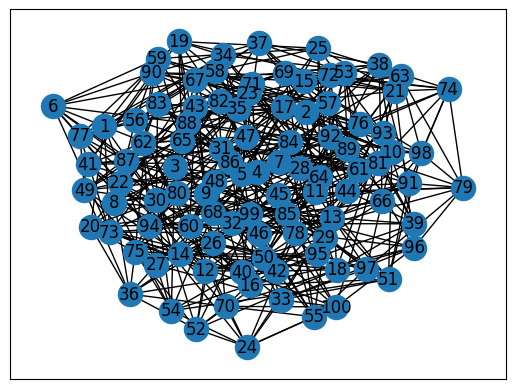

In [5]:
# Physical network
Gp=GeneratePhysicalNetwork()
nx.draw_networkx(Gp)

### VIRTUAL NETWORK

In [6]:
minvCPU = 1
maxvCPU = 50

minvBW= 1
maxvBW = 50

minNumNodesV = 4
maxNumNodesV = 8


def GenerateVirtualNetwork( NumVNodes ):
    degree = (NumVNodes-1)/2
    # Number of nodes x degree has to be an even number
    product =  math.ceil(NumVNodes*degree/2.0) * 2
    # Thus, the degree has to be:
    degree = math.ceil(product/NumVNodes)
    Gv = nx.random_regular_graph( degree, NumVNodes )
    # Fill the nodes and links attributes
    GenerateAttribNetworkNodes( Gv, minvCPU, maxvCPU )
    GenerateAttribNetworkLinks( Gv, minvBW, maxvBW )

    # We will save the physical node where the virtual node is embedded
    for n in list(Gv.nodes()):
        Gv.nodes[n]['PNode'] = 0
    for edge in list(Gv.edges()):
        Gv.edges[edge]['hops'] = 0
        Gv.edges[edge]['path'] = []

    # Relabel the number of nodes to start from 1 (instead of 0)
    Gv=nx.convert_node_labels_to_integers(Gv, first_label=1, ordering='sorted', label_attribute=None)
    
    return Gv
    

## MODEL

In [7]:
'''Function to create the MILP mathematical model'''
def milp( Gp, Gv ):
    # Create a mathematical model (MILP)
    model = ConcreteModel()
    
    #################
    ## Parameters  ##
    #################
    
    # Set of phy and vir nodes
    model.N = RangeSet(1,NumNodes)
    model.V = RangeSet(1,NumVNodes)
    
    # set of phy nodes and edges
    model.Np = Set(initialize = list(Gp.nodes))
    model.Ep = Set(initialize = list(Gp.edges))
    
    # set of vir nodes and edges
    model.Nv = Set(initialize = list(Gv.nodes))
    model.Ev = Set(initialize = list(Gv.edges))
                   
    
    # phy attributes
    model.cpu_p = Param(model.Np, initialize = nx.get_node_attributes(Gp, 'cpu'))
    model.bw_p = Param(model.Ep, initialize = nx.get_edge_attributes(Gp, 'bw'))
    model.loc_p = Param(model.Np, initialize = nx.get_node_attributes(Gp, 'loc'))
    
    
    # vir attributes
    model.cpu_v = Param(model.Nv, initialize = nx.get_node_attributes(Gv, 'cpu'))
    model.bw_v = Param(model.Ev, initialize = nx.get_edge_attributes(Gv, 'bw'))
    model.loc_v = Param(model.Nv, initialize = nx.get_node_attributes(Gv, 'loc'))
    
    
    # Maximum distance between physical nodes and virtual nodes
    model.D = Param(initialize=400)
    
    
    ################
    ## Variables  ##
    ################
    
    model.x = Var(model.Np, model.Nv, within=Binary, initialize=0)
    model.y = Var(model.Ep, model.Ev, within=Binary, initialize=0)
    
    
    ############
    ## MODEL  ##
    ############
    
    # OBJECTIVE FUNCION
    def Objective_rule(model):
        return sum(model.x[i,s]*model.cpu_v[s] for i in model.Np for s in model.Nv) + \
                   sum(model.y[i,j,s,t]*model.bw_v[s,t] for i,j in model.Ep for s,t in model.Ev)
    model.Objective = Objective(rule=Objective_rule, sense=minimize)
    
    # CONSTRAINTS
    def cpu_rule(model, i, s):
        return (model.x[i,s]*model.cpu_v[s])<= (model.cpu_p[i])
    model.cpu_rule = Constraint(model.Np, model.Nv, rule=cpu_rule)
    
    def distance_rule(model,i,s):
        return model.x[i,s]*Distance(model.loc_v[s], model.loc_p[i]) <= model.D
    
    model.distance_rule = Constraint(model.Np, model.Nv, rule = distance_rule)
    
    # one v node to at most 1 p node
    def vlimit_rule(model,i):
        return sum(model.x[i,s] for s in model.Nv) <= 1
    model.vlimit = Constraint(model.Np, rule = vlimit_rule)
    
    # node embedding
    def node_rule(model,s):
        return sum(model.x[i,s] for i in model.Np) == 1
    model.node_rule = Constraint(model.Nv, rule = node_rule)
    
    def bw_rule(model,i,j):
        return sum(model.y[i,j,s,t]*model.bw_v[s,t] for s,t in model.Ev) <= model.bw_p[i,j]
    model.bw_rule = Constraint(model.Ep, rule=bw_rule)
    
    def flow_rule(model,i,s,t):
        in1 = sum(model.y[i,j,s,t] for j in model.Np if (i,j) in model.Ep)
        in2 = sum(model.y[j,i,s,t] for j in model.Np if (j,i) in model.Ep)
        inflow = in1 - in2
        outflow = model.x[i,s]-model.x[i,t]
        return inflow == outflow
        
    model.flow = Constraint(model.Np, model.Ev, rule=flow_rule)


    return model


In [8]:
'''Function to reserve the resources already occupied in the physical network'''
def RemoveResourcesOccupied(Gp, Gv):
    # Step 1: Reserve node CPU resources
    for v_node in Gv.nodes():
        # Find the physical node to which the virtual node is mapped
        p_node = Gv.nodes[v_node]['PNode']
        
        if p_node != 0:  # If the virtual node is embedded on a physical node
            # Deduct the virtual node's CPU requirement from the physical node
            Gp.nodes[p_node]['cpu'] -= Gv.nodes[v_node]['cpu']
            Gp.nodes[p_node]['numVNodes'] += 1  # Track how many virtual nodes are embedded here

    # Step 2: Reserve link bandwidth resources
    for v_edge in Gv.edges():
        # Find the physical edges to which the virtual link is mapped
        v_node_1 = v_edge[0]
        v_node_2 = v_edge[1]
        
        # Get the physical nodes to which these virtual nodes are embedded
        p_node_1 = Gv.nodes[v_node_1]['PNode']
        p_node_2 = Gv.nodes[v_node_2]['PNode']
        
        if p_node_1 != 0 and p_node_2 != 0:  # If both virtual nodes are embedded on physical nodes
            # Find the corresponding physical edge between p_node_1 and p_node_2
            if (p_node_1, p_node_2) in Gp.edges:
                edge = (p_node_1, p_node_2)
            elif (p_node_2, p_node_1) in Gp.edges:
                edge = (p_node_2, p_node_1)
            else:
                continue  # If there is no such physical edge, skip

            # Deduct the virtual link's bandwidth requirement from the physical link
            Gp.edges[edge]['bw'] -= Gv.edges[v_edge]['bw']
            Gp.edges[edge]['numVLinks'] += 1  # Track how many virtual links are embedded here

    return Gp

In [9]:
'''Function to recover the resources previously occupied in the physical network by a virtual network'''
'''listBWs contains a list of physical links that contain the virtual links'''

def RecoverResourcesOccupied(Gp, Gv, listBWs):
    # Step 1: Recover node CPU resources
    for v_node in Gv.nodes():
        # Get the physical node where the virtual node was embedded
        p_node = Gv.nodes[v_node]['PNode']
        
        if p_node != 0:  # If the virtual node is embedded on a physical node
            # Add back the virtual node's CPU resources to the physical node
            Gp.nodes[p_node]['cpu'] += Gv.nodes[v_node]['cpu']
            Gp.nodes[p_node]['numVNodes'] -= 1  # Decrease the count of virtual nodes embedded here
            Gv.nodes[v_node]['PNode'] = 0  # Reset the PNode of the virtual node
    
    # Step 2: Recover link bandwidth resources
    for v_edge in Gv.edges():
        # Get the physical nodes corresponding to the virtual edge
        v_node_1 = v_edge[0]
        v_node_2 = v_edge[1]
        
        # Get the physical nodes to which these virtual nodes are embedded
        p_node_1 = Gv.nodes[v_node_1]['PNode']
        p_node_2 = Gv.nodes[v_node_2]['PNode']
        
        if p_node_1 != 0 and p_node_2 != 0:  # If both virtual nodes are embedded on physical nodes
            # Find the corresponding physical edge between p_node_1 and p_node_2
            if (p_node_1, p_node_2) in Gp.edges:
                edge = (p_node_1, p_node_2)
            elif (p_node_2, p_node_1) in Gp.edges:
                edge = (p_node_2, p_node_1)
            else:
                continue  # If no corresponding physical edge, skip

            # Add back the virtual link's bandwidth to the physical link
            Gp.edges[edge]['bw'] += Gv.edges[v_edge]['bw']
            Gp.edges[edge]['numVLinks'] -= 1  # Decrease the count of virtual links embedded here
            Gv.edges[v_edge]['bw'] = 0  # Reset the bandwidth of the virtual link
    
    # Step 3: Recover bandwidth from the physical links that were used for virtual links
    for bw_edge in listBWs:
        if bw_edge in Gp.edges:
            # Add back any resources previously occupied in the physical link
            Gp.edges[bw_edge]['bw'] += Gp.edges[bw_edge].get('bw', 0)
            Gp.edges[bw_edge]['numVLinks'] = 0  # Reset the count of virtual links on this physical link

    return Gp, Gv


In [10]:
# Save the results at the database ResultsUseCase1.db (inside the directory 'Results')

db = sqlite3.connect("./ResultsMILP/ResultsUseCase1.db")
cursor = db.cursor()
cursor.execute('''DROP TABLE  IF EXISTS Table1''')

db.commit()

cursor.execute('''CREATE TABLE Table1( id INTEGER PRIMARY KEY, 
                Time REAL, AcceptanceRatio REAL )
               ''')

db.commit()

In [12]:
# MAIN LOOP OF THE PROGRAM


# Maintain a list of Graphs (virtual networks), their durations, 
# and reserved BW in all the physical links used for each virtual link
listOfGraphs = {}
listOfDurations = {}
listOfReservedBW = {}


# Counters for the arrivals of VNR and the number of successful
VNRsucc=0
VNRarri=0

# Units of time of the complete simulation
totalTime = 1000

# Parameters of a virtual network
rate=6/100   # 6 request each 100 units of time
avDuration = 50 # Average Lifetime of each request

# Poisson arrivals for the VNR (Virtual Network Requests)
distribRequest = numpy.random.poisson( rate, totalTime )
while sum(distribRequest)==0: # it could happen in a Poisson process 
    distribRequest = numpy.random.poisson( rate, totalTime )

numTotalRequest = sum(distribRequest)

# The duration of each VN follows an exponential distribution with average avDuration
distribDuration = numpy.random.exponential( avDuration, numTotalRequest )

# The number of nodes of the VNR is uniformly distributed between minNumNodesV and maxNumNodesV
# We get one value for each arrival (so, numTotalRequest)
distribNumNodes = numpy.random.randint( minNumNodesV, maxNumNodesV, \
                                       numTotalRequest )


# Execute the embedding model for all the VNR of each instant of time during TotalTime

for currentInstant in range(1,totalTime):
    
    # Let's see if there are VN that finalize at the current instant of time
    for key in listOfDurations.keys():
        if listOfDurations[key] == currentInstant:
            # get the virtual network that finish now
            Gv = listOfGraphs[key] 
            # recover the resources occupied by this VN
            RecoverResourcesOccupied( Gp, Gv, listOfReservedBW[key] )
            
    # For all the request in the current instant of time
    for numReq in range(distribRequest[currentInstant]): 
        
        # Create the VN and get its duration
        Gv = GenerateVirtualNetwork(distribNumNodes[VNRarri])
        duration = math.ceil(distribDuration[VNRarri])
        NumVNodes = distribNumNodes[VNRarri]
        VNRarri += 1
        
         # create the model
        model = milp( Gp, Gv )
        
        # solve the model
        start_time = time.time()
        solver = SolverFactory('glpk')
        results = solver.solve(model)
        tsolv = time.time()-start_time
        
        print('\nCURRENT INSTANT:',currentInstant+1)
        
        print('\n Model computation time: %.4f ' %tsolv, 'seconds')
        
        if (results.solver.status == SolverStatus.ok) and \
           (results.solver.termination_condition == TerminationCondition.optimal):
            
            print('\n >>>> Virtual Network',VNRarri,'\n')
            # Let's see the results of the embedding procedure
            
            for i in Gp.nodes():
                for s in Gv.nodes():
                    if model.x[i,s].value==1: 
                        Gv.nodes[s]['PNode']=i #virtual node s embedded in physical node i
                        print('virtual node',s,'embedded in Physical node', i)
                        print('  --> physical node', i, 'decreases cpu in', \
                              model.cpu_v[s])
                        
            listResBW= {}
            for s,t in model.Ev:
                print('virtual link (',s,',',t,') is routed through the following physical links:')
                listResBW[s,t]={}
                for i,j in model.Ep:
                    if model.y[i,j,s,t].value==1:
                        print('  --> link(',i,',',j,'), its bw reduces in', model.bw_v[s,t])
                        listResBW[s,t][i,j] = model.bw_v[s,t]
                    
            
            # Save results
            listOfReservedBW[VNRarri] = listResBW
            listOfDurations[VNRarri] = currentInstant + duration
            listOfGraphs[VNRarri] = Gv.copy(as_view=False)
            
            # One more successfully embedded
            VNRsucc += 1

            # Save acceptance ratio at the database of hte current instant of time
            cursor.execute('''INSERT INTO Table1(Time,AcceptanceRatio) 
                              VALUES(?,?)''', 
                             (currentInstant,VNRsucc/VNRarri))
            db.commit()
            
            # Remove the occupied resources of the physical network
            RemoveResourcesOccupied( Gp, Gv )

        elif (results.solver.termination_condition == TerminationCondition.infeasible):
            print('   INFEASIBLE\n')
            
        else:
            # Something else is wrong
            print ("   Solver Status: ",  result.solver.status,'\n')
        
        Gv.clear()
        


print('\n\nAcceptance ratio:',VNRsucc/VNRarri)

/tmp/ipykernel_26843/2458749659.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return round(math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2),2)



CURRENT INSTANT: 3

 Model computation time: 0.4643  seconds

 >>>> Virtual Network 1 

virtual node 3 embedded in Physical node 90
  --> physical node 90 decreases cpu in 40
virtual node 1 embedded in Physical node 4
  --> physical node 4 decreases cpu in 46
virtual node 2 embedded in Physical node 61
  --> physical node 61 decreases cpu in 9
virtual node 5 embedded in Physical node 53
  --> physical node 53 decreases cpu in 15
virtual node 4 embedded in Physical node 65
  --> physical node 65 decreases cpu in 29
virtual node 6 embedded in Physical node 82
  --> physical node 82 decreases cpu in 49
virtual link ( 1 , 2 ) is routed through the following physical links:
  --> link( 4 , 61 ), its bw reduces in 12
virtual link ( 1 , 5 ) is routed through the following physical links:
  --> link( 4 , 53 ), its bw reduces in 10
virtual link ( 1 , 6 ) is routed through the following physical links:
  --> link( 4 , 82 ), its bw reduces in 11
virtual link ( 2 , 5 ) is routed through the follo

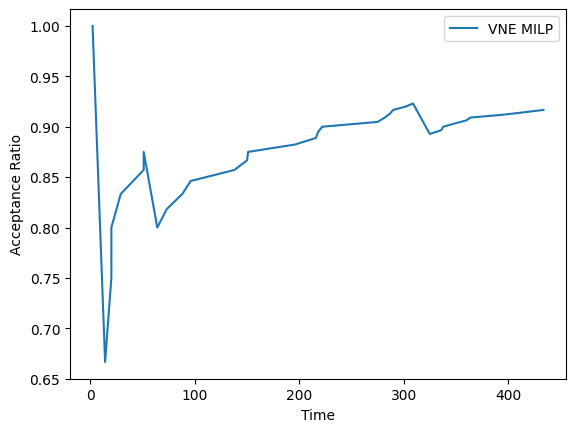

In [13]:
# Plot the acceptance ratio with respect to the time
import matplotlib.pyplot

db = sqlite3.connect("./ResultsMILP/ResultsUseCase1.db")
cursor = db.cursor()

cursor.execute("SELECT Time,AcceptanceRatio FROM Table1")
 
data = cursor.fetchall()

t = [data[i][0] for i in range(len(data))]
a = [data[i][1] for i in range(len(data))]

# Plot the data
matplotlib.pyplot.plot(t,a, label='VNE MILP')

matplotlib.pyplot.xlabel("Time")
matplotlib.pyplot.ylabel("Acceptance Ratio")


# Add a legend
matplotlib.pyplot.legend()

# Show the plot
matplotlib.pyplot.show()

